# The NYU finger robot

The robot is constituted of 4 rigid bodies together 3 joints. There is one motor per joint and we can send a desired torque to each motor and read the position (angle) and velocity of each joint using the position sensor attached on each motor (the internal software computes the velocities using finite differences).

<img src="images/finger_edu_1.jpg" width=600>

More details on the robot are avaiable [here](https://github.com/open-dynamic-robot-initiative/open_robot_actuator_hardware/blob/master/mechanics/finger_edu_v1/README.md#fingeredu-v1)


# PyBullet - a robot simulator

[PyBullet](https://pybullet.org/wordpress/) is a "rigid body dynamics" simulator, it means that it can simulate any articulated, rigid, robot. For example our NYU finger but also more complex robots, such as a humanoid, a quadruped or a hand. It can also simulate other objects and several robots at the same time.

## How does it work?

In a nutshell, every simulator functions as follows:
* First a description of the objects and robots to simulate are given, including their dynamic properties (masses, center of mass), their "boundaries" (to detect collisions between objects) and graphic files to visualize the robot. The visualization is often different than what is simulated (i.e. we often simplify the geometry of the robot, e.g. using cylinders, for the simulation but display all the details in the visualization)

* At each instant of time, the simulator keeps track of all the collisions between all the objects, to know where to compute contact forces. Typically the collisions are simplified to make the simulation fast enough.

* The simulator then computes all the forces exerted on all the objects and robots (e.g. gravity, contact between objects, etc) and uses Netwon's law of motion to compute the next position and velocity of all the objects.

<img src="images/simulation_loop.jpg" width=400>


The user can then decide to apply forces/torques on certain joints, like a motor would do and read all the available information from the simulator to emulate real sensors.

As a user, we then need to write a "controller" that decides what to do at each simulation step.


## Working with the real robot
Each robot has different interfaces to be able to read its sensors and send control commands, which can be different from the robot simulator code. For this laboratory, we have wrapped all the functionality needed from PyBullet into the class NYUFingerSimulator located in the file [nyu_finger_simulator.py](./nyu_finger_simulator.py) which also contains the same functions to control the real robot. Therefore, the controllers you write will work both in the simulator and the real robot.

We detail below the typical control loop we will use throughout the class.

# Typical control loops with sensors and actuators

We discuss in this section how we can make the robot move by sending motor commands.

Every robot comes with a set of actuators that need to be controlled. Typically, a set of "low-level" controllers are available such that one can send a desired motor torque or a desired joint position and the robot controller will transform this into a current to modulate the rotation of an electric motor or the opening/closing of a pneumatic or hydraulic valve. This in turn will create a movement of the robot.

In our class, we will assume that we can send a desired joint torque and that it will be achieved on the robot. PyBullet enables the same level of "abstraction" which is sufficient for most robot applications.

We will now see how we can send desired motor torques to the robot.

## A typical control loop

Here is a typical control loop (what you need to design to control a robot):
1. First read the sensors
2. Compute the desired torque commands
3. Send the commands to the motors
4. Repeat periodically (typically at a rate of ~100Hz to 1KHz)

The example was doing "open loop" control because we did not use the sensor measurement to compute the desired commands. "Closed loop" control will make use of the sensors to compute the control commands.

<img src="images/control_loop.png" width=600>

## Example of a simple control loop with the simulation

In [1]:
#setup nice plotting
%matplotlib notebook

# we import useful libraries including numpy for easy algebra and matplot for plotting
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# we import the helper class to work with either the simulation or real robot
use_real_robot = False

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator
    


pybullet build time: Aug 21 2022 18:46:39


In [2]:
## if we are using the real robot
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerReal()
    
    # Make sure that the motor number matches that on the robot
    motor_number = np.array([1,2,3])
    robot.initialize('ens1', motor_number)
    
## if we are using the simulation
else:
    # we can now create a robot simulation
    robot = NYUFingerSimulator()

In [3]:
# we can now send a desired motor command and simulate the behavior of the robot
# we send 0.1Nm on the first joint
# we also record the measured state of the robot

# below is a sample code to run the simulation / collect sensor and command data


# we simulate for 5 seconds
run_time = 5.
dt = 0.001

num_steps = int(run_time/dt)


## we allocate a few vectors to collect data while we do the simulation
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
desired_torques = np.zeros_like(measured_positions)
time = np.zeros([num_steps])

## this is our main control loop ##
## we do the loop for num_steps ##
for i in range(num_steps):
    
    # get the current time
    time[i] = dt * i
    
    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot.get_state()
    
    # we store these values for later use
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # we compute the desired torques
    # here we send a constant torque to each joint
    joint_torques = np.array([0.05*np.sin(np.pi*2.*time[i]),0.,0.])
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot
    robot.send_joint_torque(joint_torques)
    
    # we ask the simulator to do one simulation step
    robot.step()    

## Plotting data after the simulation

<IPython.core.display.Javascript object>


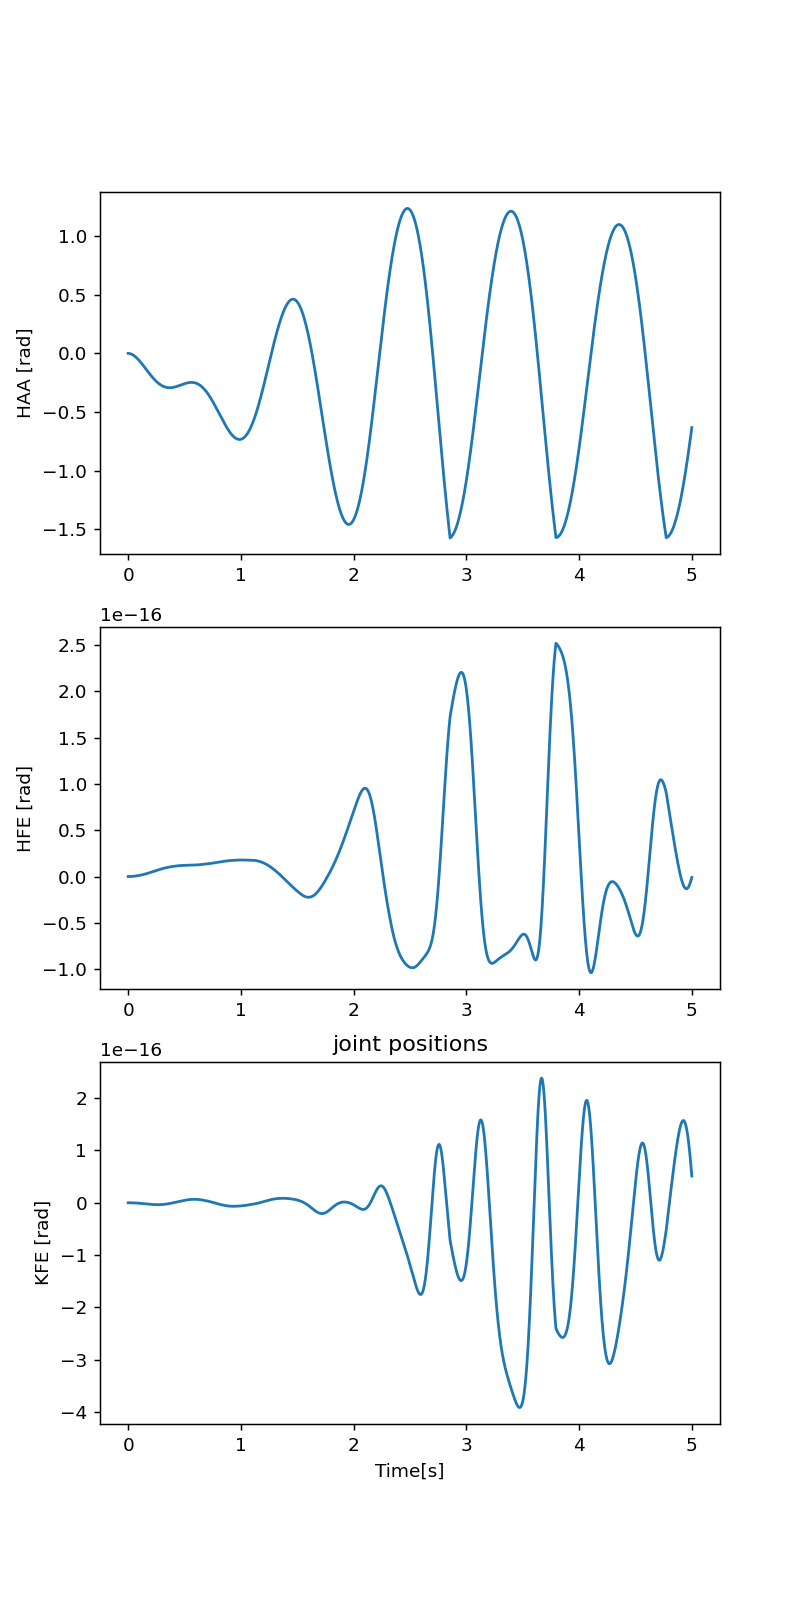

<IPython.core.display.Javascript object>


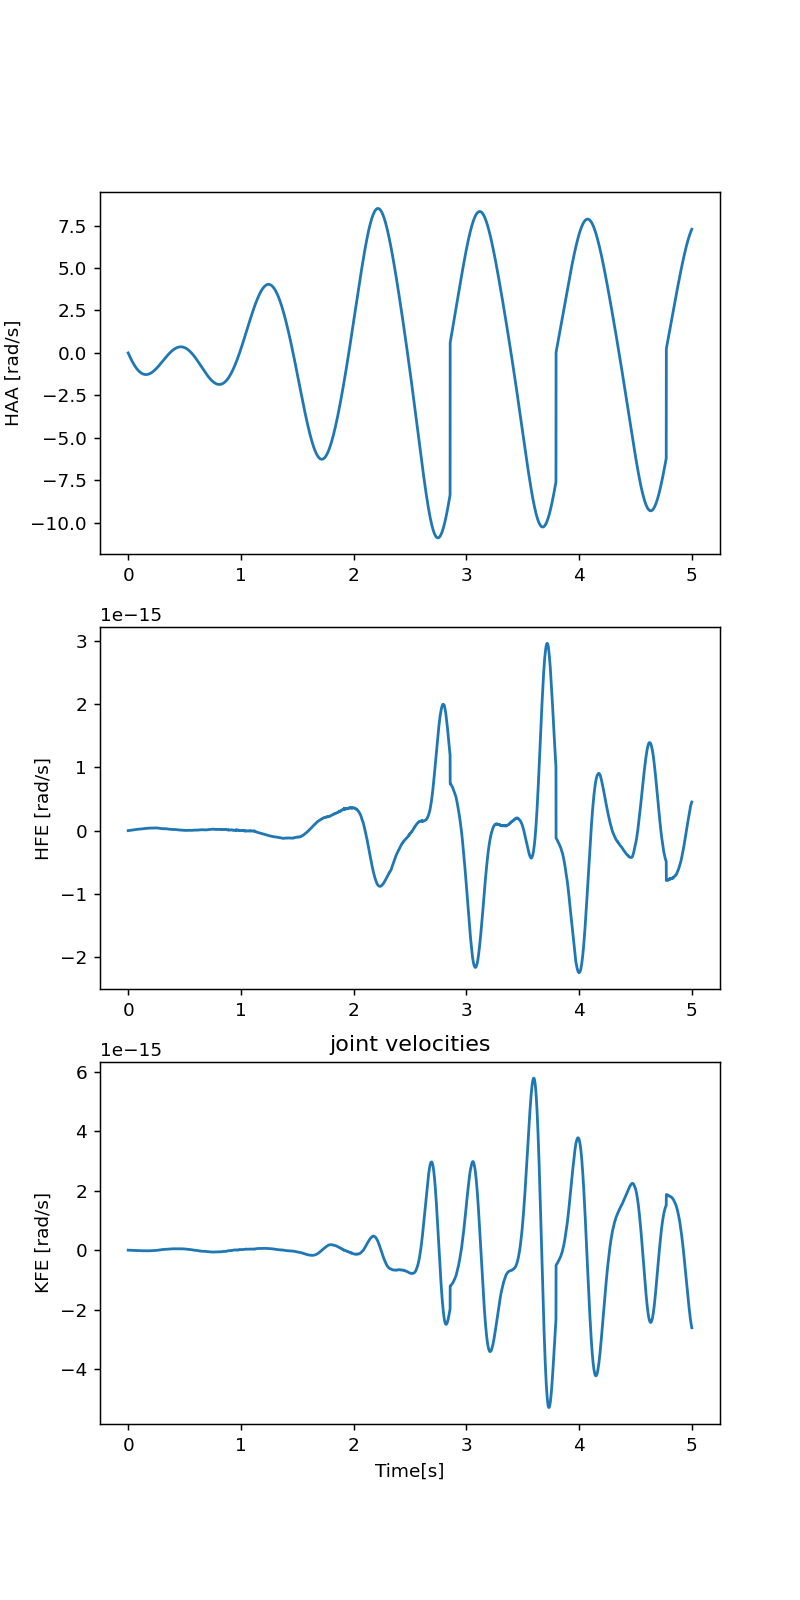

Text(0.5, 1.0, 'joint velocities')

In [4]:
# we plot the measured position and velocities of all the joints
plt.figure(figsize=[6, 12])
joint_names = ["HAA", "HFE", "KFE"]

# plot the positions
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(time, measured_positions[:,i])
    plt.ylabel(joint_names[i] + ' [rad]')
plt.xlabel('Time[s]')
plt.title('joint positions')

# plot the velocities
plt.figure(figsize=[6, 12])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(time, measured_velocities[:,i])
    plt.ylabel(joint_names[i] + ' [rad/s]')
plt.xlabel('Time[s]')
plt.title('joint velocities')

## Questions:
(submit a pdf with detailed answers to these questions, including the plots through Brightspace)
1. What is the control rate that we used in this example in Hz?

2. Describe the behavior of the robot when 0.1 Nm is applied to the 1st joint and 0 Nm applied to the others. What is the physical explanation for this behavior (in words)?

3. Apply a periodic torque of $0.05\sin(2\pi t)$ Nm on the first joint. What do you observe? Join a plot of the position and velocity for each joint. (start from the same initial pose for the robot)

4. Answer 2 and 3 using the real robot - compare with the results in simulation.